In [3]:
# Import necessary libraries
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Check current working directory
print("Current working directory:", os.getcwd())

# Load dataset from the correct path
# Update the path below if necessary
csv_path = 'Data/Raw/stores_sales_forecasting.csv'
if not os.path.exists(csv_path):
	print(f"File not found: {csv_path}")
else:
	df = pd.read_csv(csv_path, encoding='latin1')

Current working directory: /Users/huzaifamahmood/Desktop/projects/Level 2/Sales Forecasting with Time-Series Analysis


In [6]:
# --- Basic Preparation ---
# Convert 'Order Date' to a proper datetime object, handling mixed formats
df['Order Date'] = pd.to_datetime(df['Order Date'], format='mixed', dayfirst=True)

# Set 'Order Date' as the index for time-series operations
df.set_index('Order Date', inplace=True)

# Ensure the data is sorted by date
df.sort_index(inplace=True)

print("Data loaded and initial preparation is complete.")
display(df.head())

Data loaded and initial preparation is complete.


,Row ID,Order ID,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
Order Date,,,,,,,,,,,,,,,,,,,,
2014-01-03,7949,CA-2014-131009,3/5/2014,Standard Class,SC-20380,Shahid Collister,Consumer,United States,El Paso,Texas,79907,Central,FUR-CH-10001270,Furniture,Chairs,Harbour Creations Steel Folding Chair,362.250,6,0.3,0.0000
2014-01-03,7950,CA-2014-131009,3/5/2014,Standard Class,SC-20380,Shahid Collister,Consumer,United States,El Paso,Texas,79907,Central,FUR-FU-10001095,Furniture,Furnishings,DAX Black Cherry Wood-Tone Poster Frame,63.552,6,0.6,-34.9536
2014-01-03,8311,CA-2014-168312,3/7/2014,Standard Class,GW-14605,Giulietta Weimer,Consumer,United States,Houston,Texas,77036,Central,FUR-TA-10001866,Furniture,Tables,Bevis Round Conference Room Tables and Bases,376.509,3,0.3,-43.0296
2014-01-03,6548,CA-2014-113880,3/5/2014,Standard Class,VF-21715,Vicky Freymann,Home Office,United States,Elmhurst,Illinois,60126,Central,FUR-CH-10000863,Furniture,Chairs,Novimex Swivel Fabric Task Chair,634.116,6,0.3,-172.1172
2014-01-03,158,CA-2014-104269,3/6/2014,Second Class,DB-13060,Dave Brooks,Consumer,United States,Seattle,Washington,98115,West,FUR-CH-10004063,Furniture,Chairs,Global Deluxe High-Back Manager's Chair,457.568,2,0.2,51.4764


In [7]:
# Check for the number of duplicate rows
num_duplicates = df.duplicated().sum()
print(f"Found {num_duplicates} duplicate rows.")

# Remove duplicates if any are found
if num_duplicates > 0:
    df.drop_duplicates(inplace=True)
    print("Duplicate rows have been removed.")

Found 0 duplicate rows.


In [8]:
# Calculate Q1, Q3, and IQR for the 'Sales' column
Q1 = df['Sales'].quantile(0.25)
Q3 = df['Sales'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier upper bound
upper_bound = Q3 + 1.5 * IQR

print(f"The upper bound for sales is: ${upper_bound:.2f}")

# Cap the outliers
# .loc is used to access a group of rows and columns by label(s).
# Here, we're selecting rows where 'Sales' > upper_bound and only the 'Sales' column.
df.loc[df['Sales'] > upper_bound, 'Sales'] = upper_bound

print("Outliers in the 'Sales' column have been capped.")

The upper bound for sales is: $1017.36
Outliers in the 'Sales' column have been capped.


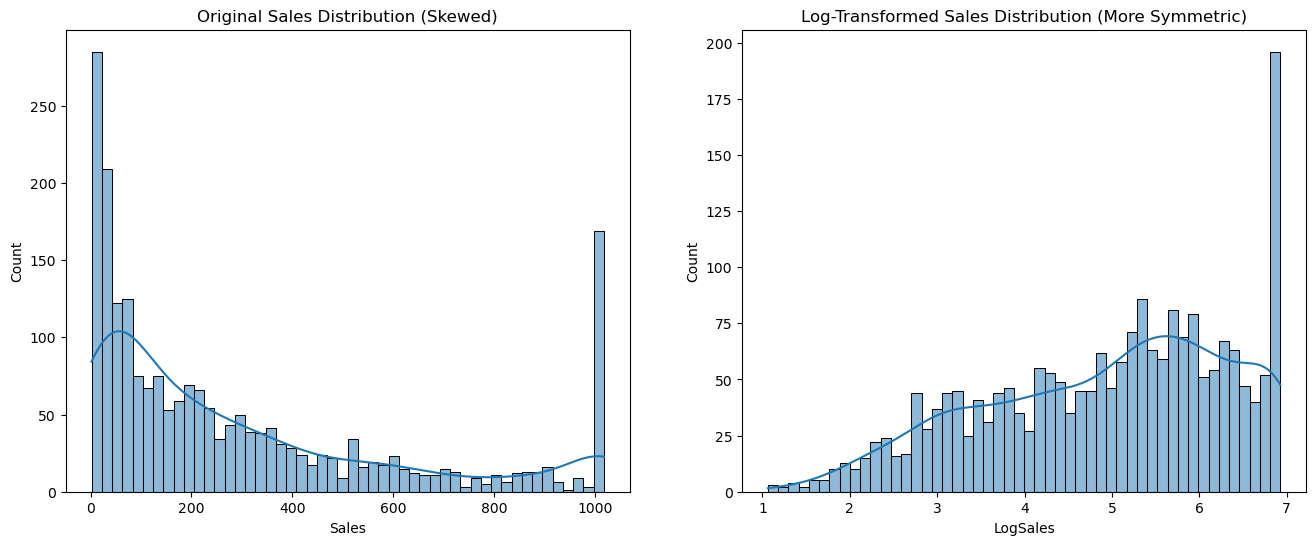

In [10]:
# Apply the log transformation to the 'Sales' column
# We add 1 to avoid issues with log(0) if any sales were 0.
df['LogSales'] = np.log1p(df['Sales'])

# Visualize the effect of the log transformation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot original distribution
sns.histplot(df['Sales'], kde=True, ax=axes[0], bins=50)
axes[0].set_title('Original Sales Distribution (Skewed)')

# Plot transformed distribution
sns.histplot(df['LogSales'], kde=True, ax=axes[1], bins=50)
axes[1].set_title('Log-Transformed Sales Distribution (More Symmetric)')

plt.show()

Created the final daily sales time series:


Order Date
2014-01-03    1893.995
2014-01-04       0.000
2014-01-05       0.000
2014-01-06    1039.560
2014-01-07       0.000
Freq: D, Name: Sales, dtype: float64

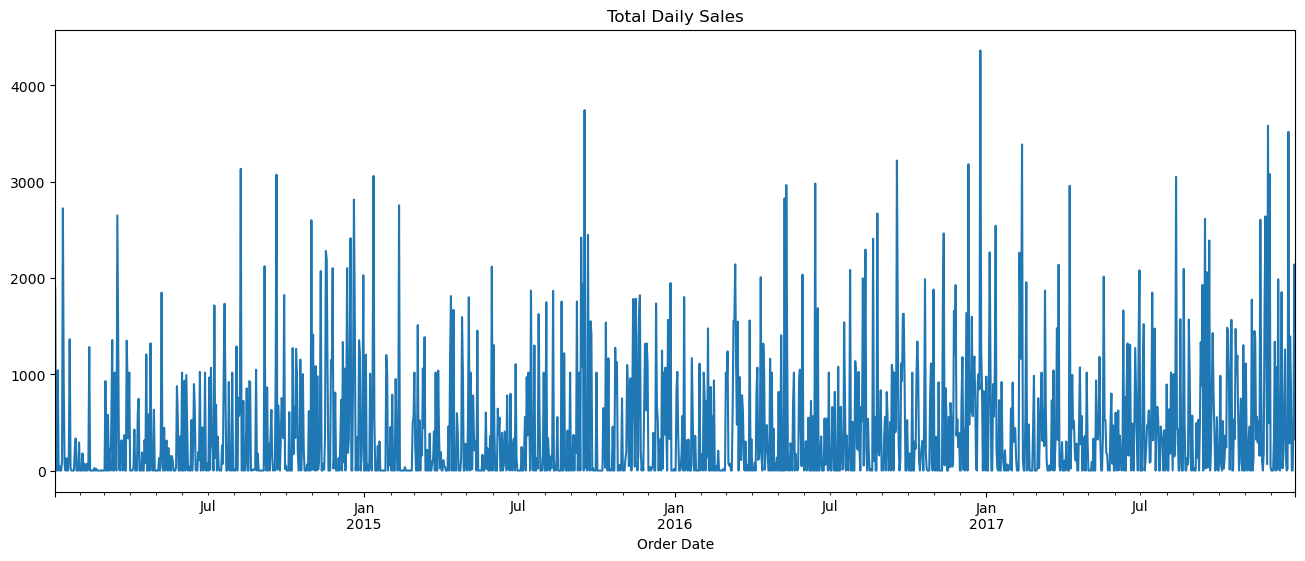

In [12]:
# We are interested in forecasting total sales, so we only need the sales column.
# Let's resample to get the total daily sales. 'D' stands for 'Day'.
# We use .sum() to aggregate all sales within the same day.
daily_sales = df['Sales'].resample('D').sum()

# It's possible some days had no sales. Let's fill these with 0.
daily_sales = daily_sales.fillna(0)

print("Created the final daily sales time series:")
display(daily_sales.head())

# Let's also plot our final aggregated time series
plt.figure(figsize=(16,6))
plt.title('Total Daily Sales')
daily_sales.plot()
plt.show()

Training data runs from 2014-01-03 00:00:00 to 2017-12-29 00:00:00
Testing data runs from 2017-12-29 00:00:00 to 2017-12-30 00:00:00
Shape of training data: (1457,)
Shape of testing data: (2,)


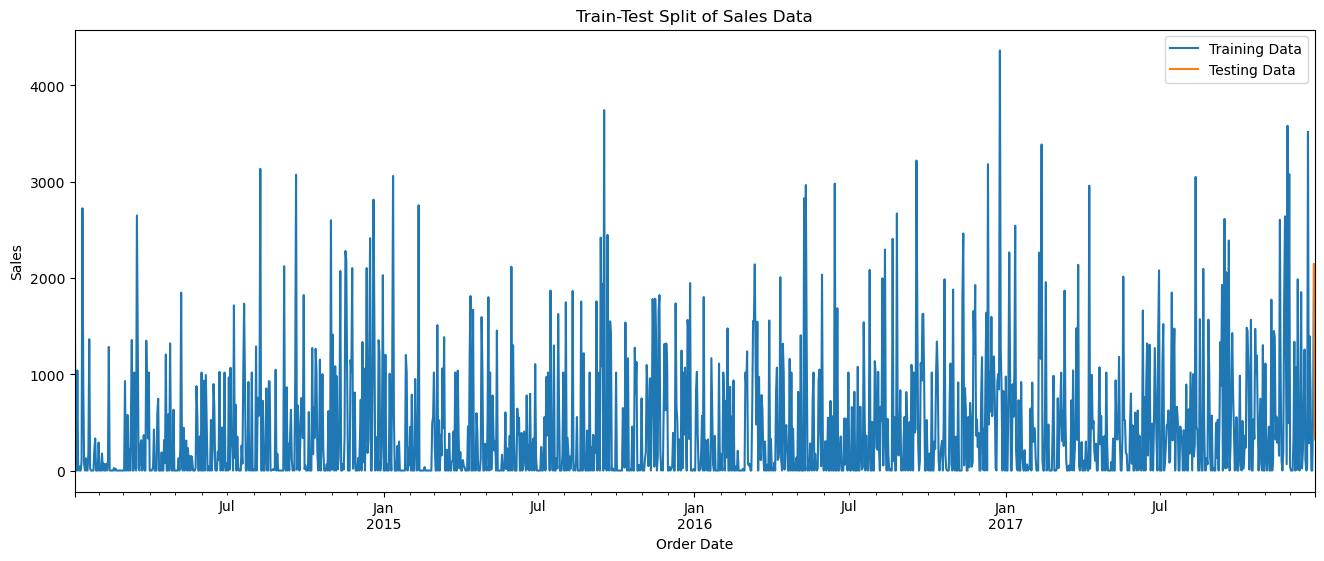

In [14]:
# Define the cutoff date for the split
cutoff_date = '2017-12-29'  # Last date in training set

# Split the data into training and testing sets
train_data = daily_sales[:cutoff_date]
test_data = daily_sales[cutoff_date:]

print(f"Training data runs from {train_data.index.min()} to {train_data.index.max()}")
print(f"Testing data runs from {test_data.index.min()} to {test_data.index.max()}")
print(f"Shape of training data: {train_data.shape}")
print(f"Shape of testing data: {test_data.shape}")

# Plot the split
plt.figure(figsize=(16, 6))
plt.title('Train-Test Split of Sales Data')
plt.xlabel('Date')
plt.ylabel('Sales')
train_data.plot(label='Training Data')
test_data.plot(label='Testing Data')
plt.legend()
plt.show()

In [17]:
# Save the daily sales, train, and test splits
daily_sales.to_csv('Data/Processed/daily_sales.csv', encoding='utf-8')
train_data.to_csv('Data/Processed/train_data.csv', encoding='utf-8')
test_data.to_csv('Data/Processed/test_data.csv', encoding='utf-8')
print("Saved daily_sales, train_data, and test_data to Data/Processed/")

Saved daily_sales, train_data, and test_data to Data/Processed/
